ML4HC_Project01_Code:
Part 2


In [ ]:
!pip install torchmetrics

In [ ]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
import torchmetrics

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.io import imread, imshow
from skimage.measure import regionprops_table


In [ ]:
#install kaggle
!pip install kaggle

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# make tmp kaggle folder, add json, allow
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/ETH/MSc/kaggle.json ~/.kaggle/ #/content/drive/MyDrive/ETH/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# download and unzip dataset
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# to normalize to [0,1]
class normalize(object):
    def __call__(self, sample):
        sample = sample.float()
        sample = (sample - torch.min(sample)) / (torch.max(sample) - torch.min(sample))
        return sample

def get_data(path):
    # def transforms
    transform = transforms.Compose([
        transforms.Resize((200, 200)),  # resize
        transforms.ToTensor(),           # to PyTorch tensors, including normalization to [0, 1]
        normalize()                        # normalize to [0, 1]
    ])

    # load dataset with transforms
    dataset = datasets.ImageFolder(root=path, transform=transform)

    return dataset

In [ ]:
# loading dataset
# train_dataset = get_data('/content/drive/MyDrive/ETH/MSc/chest_xray/train')
# val_dataset = get_data('/content/drive/MyDrive/ETH/chest_xray/val')
# test_dataset = get_data('/content/drive/MyDrive/ETH/chest_xray/test')

# CHANGE THIS TO YOUR PATH TO THE 'chest_xray' folder example "/Users/Name/Downloads/chest_xray"
#'content/chest_xray'
path_to_chest_xray='/content/drive/MyDrive/ETH/MSc/ML 4 Healthcare/Project_01/chest_xray'

train_dataset = get_data(path_to_chest_xray +'/train')
val_dataset = get_data(path_to_chest_xray +'/val')
test_dataset = get_data(path_to_chest_xray + '/test')

#to dataloader
batch = 32

train = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
val = torch.utils.data.DataLoader(val_dataset, batch_size=batch, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [ ]:
train_penumonia = path_to_chest_xray + "/train/PNEUMONIA"
train_normal = path_to_chest_xray + "/train/NORMAL"
valid_penumonia = path_to_chest_xray + "/val/PNEUMONIA"
valid_normal = path_to_chest_xray + "/val/NORMAL"
test_penumonia = path_to_chest_xray + "/test/PNEUMONIA"
test_normal = path_to_chest_xray + "/test/NORMAL"

Number of training samples with pneumonia:  1957
Number of training samples with normal:  693


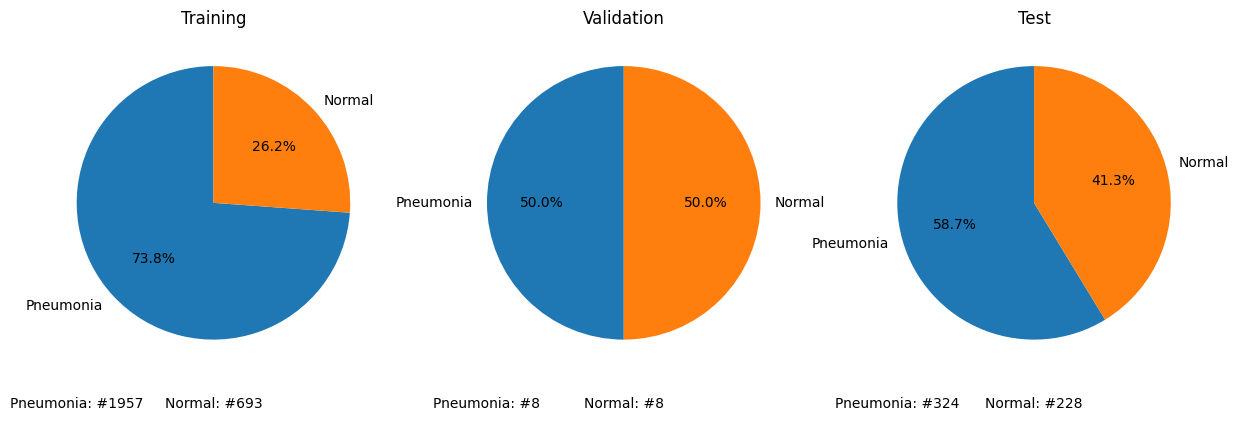

In [ ]:
import os

def count_files_in_folder(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count


n_train_penumonia,n_train_normal=count_files_in_folder(path_to_chest_xray +'/train/PNEUMONIA'), count_files_in_folder(path_to_chest_xray +'/train/NORMAL')
n_valid_normal,n_valid_penumonia=count_files_in_folder(path_to_chest_xray +'/val/NORMAL'), count_files_in_folder(path_to_chest_xray +'/val/PNEUMONIA')
n_test_normal,n_test_penumonia=count_files_in_folder(path_to_chest_xray +'/test/NORMAL'), count_files_in_folder(path_to_chest_xray +'/test/PNEUMONIA')

print("Number of training samples with pneumonia: ", n_train_penumonia)
print("Number of training samples with normal: ", n_train_normal)

import matplotlib.pyplot as plt

# Data
labels = ['Pneumonia', 'Normal']
sizes = [[n_train_penumonia, n_train_normal],[n_valid_penumonia, n_valid_normal],[n_test_penumonia, n_test_normal]]
titles = ['Training', 'Validation', 'Test']
# subplot 0
fig, ax = plt.subplots(1,3,figsize=(15,5))

for j in range(3):
    ax[j].pie(sizes[j], labels=labels, autopct='%1.1f%%', startangle=90)
    #ax[0].axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
    ax[j].set_title(titles[j])

    # Add numbers
    for i, size in enumerate(sizes[j]):
        ax[j].text(1 * i-1, -1.5,labels[i]+ ": #"+str(size), ha='center')


# Show the plot
plt.show()

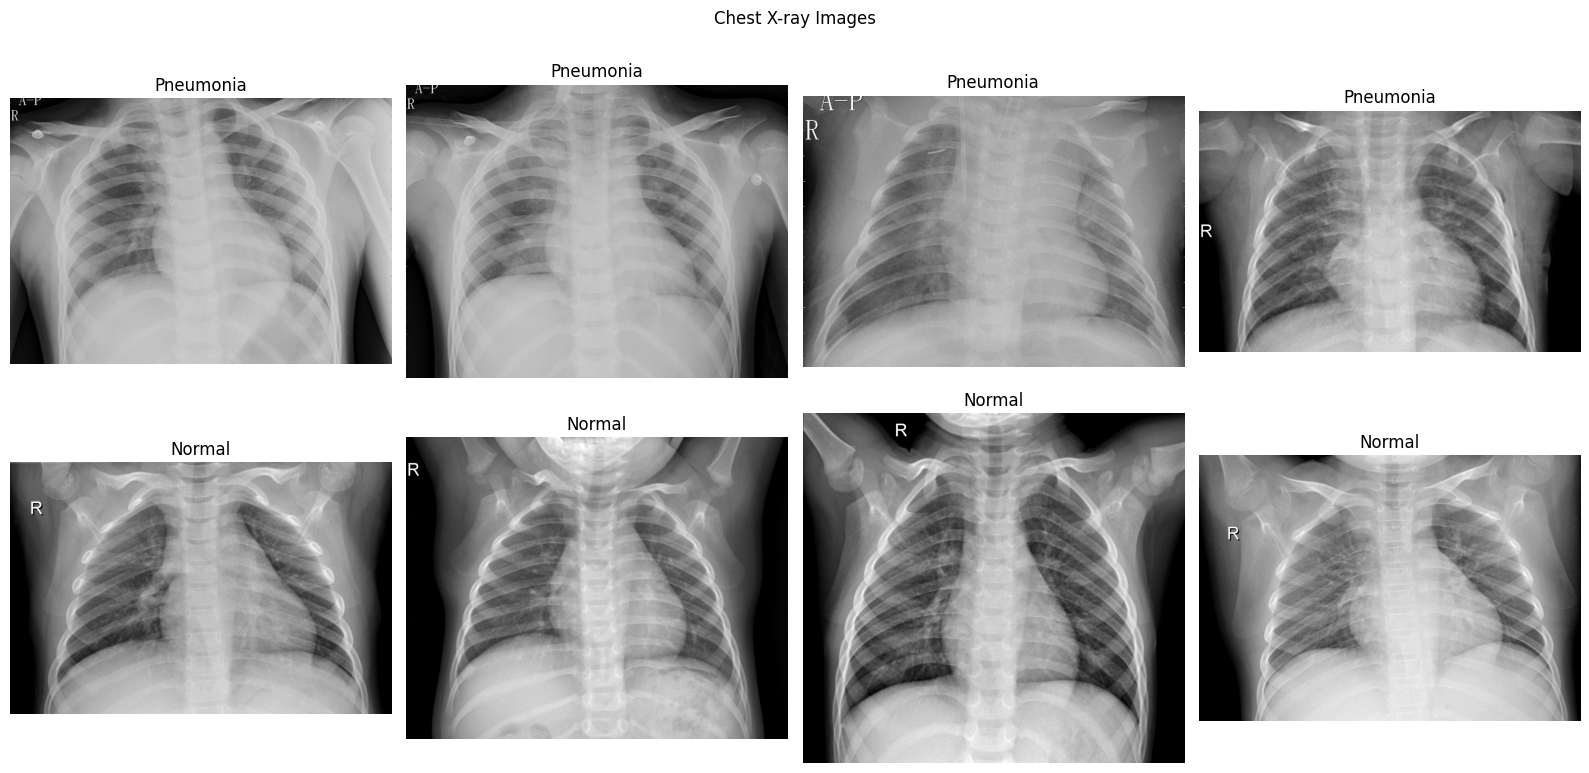

In [ ]:
import matplotlib.image as mpimg
n=4

# Get the file names of the first 3 images from train_penumonia
penumonia_files = os.listdir(train_penumonia)[:n]

# Get the file names of the first 3 images from train_normal
normal_files = os.listdir(train_normal)[:n]

# Create subplots with titles
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
fig.suptitle('Chest X-ray Images')

# Plot the images from train_penumonia
for i, file in enumerate(penumonia_files):
    img = mpimg.imread(os.path.join(train_penumonia, file))
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title('Pneumonia')

# Plot the images from train_normal
for i, file in enumerate(normal_files):
    img = mpimg.imread(os.path.join(train_normal, file))
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title('Normal')

# Remove the empty subplots
for ax in axes.flatten():
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


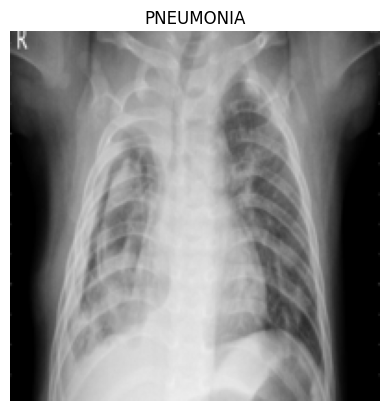

In [ ]:
# Plot one example
# get next image
images, labels = next(iter(train))

# to numpy
image = images[0].numpy()
label = labels[0].item()

# convert tensor shape (channels, height, width) to (height, width, channels)
image = np.transpose(image, (1, 2, 0))

# def classes
classes = ['NORMAL', 'PNEUMONIA']

# plot
plt.imshow(image)
plt.title(classes[label])
plt.axis('off')
plt.show()

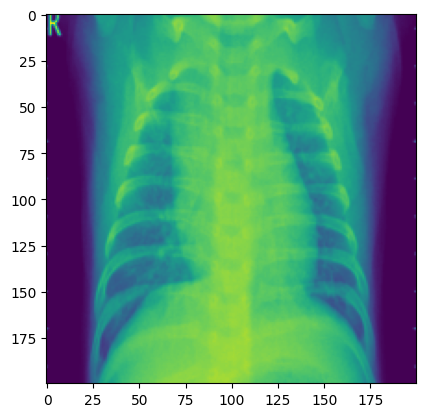

In [ ]:
#images, labels = next(iter(train))
plt.imshow(images[5,0,:,:])

In [ ]:
images[:,0,:,:].size()

torch.Size([32, 200, 200])

In [ ]:
labels.size()

torch.Size([32])

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.densenet121(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Linear(ftrs, 1) #final linear output layer

    def forward(self, x):
        x = self.model(x)
        return x

class CNNSigmoid(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        x = self.model(x)
        y = torch.sigmoid(x)
        return y


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# set
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [ ]:
# train one epoche
def train_epoch(model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    acc_train = torchmetrics.Accuracy('binary').to(device)

    for images, labels in train:

        images, labels = images.to(device), labels.to(device).to(torch.float32)

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        acc_train(outputs, labels.int())

    return model, running_loss/len(train), acc_train.compute().item()

In [ ]:
# evaluate in validatio set
def evaluate(model, criterion):
  model.eval()
  with torch.no_grad():
    val_loss = 0
    acc_valid = torchmetrics.Accuracy('binary').to(device)

    for images, labels in val:

      images, labels = images.to(device), labels.to(device).to(torch.float32)

      outputs = model(images).squeeze()
      loss = criterion(outputs, labels)

      val_loss += loss.item()
      acc_valid(outputs, labels.int())

  return val_loss/len(val), acc_valid.compute()

In [ ]:
# evaluate on test set
def evaluate_test(model, criterion):
  model.eval()
  with torch.no_grad():
    test_loss = 0
    acc_valid = torchmetrics.Accuracy('binary').to(device)

    for images, labels in test:

      images, labels = images.to(device), labels.to(device).to(torch.float32)

      outputs = model(images).squeeze()
      loss = criterion(outputs, labels)

      test_loss += loss.item()
      acc_valid(outputs, labels.int())

  return test_loss/len(test), acc_valid.compute()

In [ ]:
# train
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
  print(f"Epoch: {epoch+1}/{num_epochs}")

  model, loss_train, acc_train = train_epoch(model, criterion, optimizer)
  loss_valid, acc_valid = evaluate(model, criterion)

  acc_valid = acc_valid.cpu().numpy()
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  print(f"Train: Loss {loss_train:.2}, Accuracy {acc_train:.2}; Validation: Loss {loss_valid:.2}, Accuracy {acc_valid:.2}")

Epoch: 1/10
Train: Loss 0.41, Accuracy 0.83; Validation: Loss 0.75, Accuracy 0.62
Epoch: 2/10
Train: Loss 0.24, Accuracy 0.92; Validation: Loss 0.44, Accuracy 0.75
Epoch: 3/10
Train: Loss 0.19, Accuracy 0.94; Validation: Loss 0.5, Accuracy 0.75
Epoch: 4/10
Train: Loss 0.18, Accuracy 0.93; Validation: Loss 0.4, Accuracy 0.75
Epoch: 5/10
Train: Loss 0.16, Accuracy 0.94; Validation: Loss 0.46, Accuracy 0.75
Epoch: 6/10
Train: Loss 0.15, Accuracy 0.95; Validation: Loss 0.44, Accuracy 0.75
Epoch: 7/10
Train: Loss 0.14, Accuracy 0.95; Validation: Loss 0.54, Accuracy 0.75
Epoch: 8/10
Train: Loss 0.13, Accuracy 0.95; Validation: Loss 0.37, Accuracy 0.75
Epoch: 9/10
Train: Loss 0.12, Accuracy 0.96; Validation: Loss 0.44, Accuracy 0.75
Epoch: 10/10
Train: Loss 0.12, Accuracy 0.96; Validation: Loss 0.6, Accuracy 0.75


In [ ]:
print("loss_train_hist:", loss_train_hist)
print("loss_valid_hist:", loss_valid_hist)
print("acc_train_hist:", acc_train_hist)
print("acc_valid_hist:", acc_valid_hist)

loss_train_hist: [0.4078597359118923, 0.24167850132911436, 0.18558717074413453, 0.18177813255498487, 0.16472088845987473, 0.15314824698913482, 0.140275840076708, 0.13257427573684724, 0.12162608160607276, 0.1181218141028958]
loss_valid_hist: [0.7491426467895508, 0.44059622287750244, 0.4951293170452118, 0.40263819694519043, 0.45970237255096436, 0.4403305947780609, 0.5437748432159424, 0.36679959297180176, 0.43635499477386475, 0.5962210893630981]
acc_train_hist: [0.8265720009803772, 0.9183570146560669, 0.9396551847457886, 0.9330628514289856, 0.9421906471252441, 0.9452332854270935, 0.9497971534729004, 0.952839732170105, 0.959432065486908, 0.9609533548355103]
acc_valid_hist: [array(0.625, dtype=float32), array(0.75, dtype=float32), array(0.75, dtype=float32), array(0.75, dtype=float32), array(0.75, dtype=float32), array(0.75, dtype=float32), array(0.75, dtype=float32), array(0.75, dtype=float32), array(0.75, dtype=float32), array(0.75, dtype=float32)]


In [ ]:
print(evaluate_test(model, criterion))

(0.5850593815831577, tensor(0.7688, device='cuda:0'))


In [ ]:
torch.save(model.state_dict(), 'trained_model_240416_new.pth')
#model_save_name = 'resnet50_model_trained.pt'
#path = F"/content/gdrive/'My Drive'/{model_save_name}"
#torch.save(model.state_dict(), path)

In [ ]:
# load new saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
state_dict = torch.load('/content/drive/MyDrive/ETH/MSc/ML 4 Healthcare/Project_01/trained_model_240416_200pix_10epochs.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device)

CNN(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affi

In [ ]:
epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_train_hist, 'b', label='Training')
plt.plot(epochs, loss_valid_hist, 'r', label='Validation')
plt.title('Training and Validation - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc_train_hist, 'b', label='Training')
plt.plot(epochs, acc_valid_hist, 'r', label='Validation')
plt.title('Training and Validation - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'loss_train_hist' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
from sklearn.metrics import classification_report
targets = []
predictions = []

with torch.no_grad():
    model.eval()
    for images, labels in test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        targets.extend(labels.cpu().numpy())
        preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        predictions.extend(preds)

print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.97      0.61      0.75       228
           1       0.78      0.99      0.87       324

    accuracy                           0.83       552
   macro avg       0.88      0.80      0.81       552
weighted avg       0.86      0.83      0.82       552



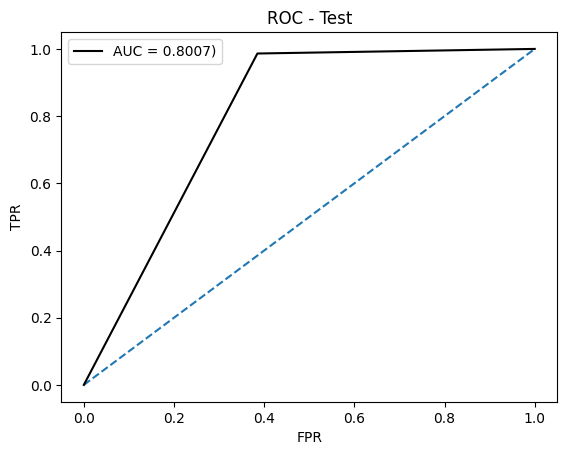

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(targets, predictions, pos_label=1)
auc = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='AUC = {:.4f})'.format(auc), color='black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - Test')
plt.legend(loc='best')
plt.show()

In [ ]:
model(images.to(device))

tensor([[ 2.1586],
        [-2.9587],
        [ 4.9384],
        [ 0.7082],
        [ 7.9850],
        [-3.6173],
        [-1.3359]], device='cuda:0', grad_fn=<AddmmBackward0>)

Integrated Gradients

In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:00


In [ ]:
from captum.attr import IntegratedGradients
attribution_list = []
random_baseline = torch.randn(torch.Size([1, 3, 200, 200]))
for (images, labels) in train:
    mean_baseline = torch.mean(images, dim=0).unsqueeze(0)
    print(mean_baseline.shape)
    break

def attribute_image_features(algorithm, input, target_index, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=target_index, **kwargs)
    return tensor_attributions

target_class_index = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# iterate batches
for batch_idx, (images, labels) in enumerate(test):
    images.to(device)
    labels.to(device)

    for img_idx, img_tensor in enumerate(images):
        input = img_tensor.unsqueeze(0).to(device)
        input.requires_grad = True

        # Integrated Gradients
        ig = IntegratedGradients(model)

        # attribute
        attr_ig, delta = attribute_image_features(ig, input, target_class_index, baselines=input * 0, return_convergence_delta=True)
        attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
        if batch_idx==0:
          attribution_list.append(attr_ig)
        print(f'Approximation delta for Batch {batch_idx}, Image {img_idx}: ', abs(delta))

torch.Size([1, 3, 200, 200])
Approximation delta for Batch 0, Image 0:  tensor([0.9009], device='cuda:0', dtype=torch.float64)
Approximation delta for Batch 0, Image 1:  tensor([1.0863], device='cuda:0', dtype=torch.float64)
Approximation delta for Batch 0, Image 2:  tensor([2.3805], device='cuda:0', dtype=torch.float64)
Approximation delta for Batch 0, Image 3:  tensor([0.3785], device='cuda:0', dtype=torch.float64)
Approximation delta for Batch 0, Image 4:  tensor([5.1961], device='cuda:0', dtype=torch.float64)
Approximation delta for Batch 0, Image 5:  tensor([0.2816], device='cuda:0', dtype=torch.float64)
Approximation delta for Batch 0, Image 6:  tensor([3.2455], device='cuda:0', dtype=torch.float64)
Approximation delta for Batch 0, Image 7:  tensor([1.1547], device='cuda:0', dtype=torch.float64)
Approximation delta for Batch 0, Image 8:  tensor([4.0351], device='cuda:0', dtype=torch.float64)
Approximation delta for Batch 0, Image 9:  tensor([0.0963], device='cuda:0', dtype=torch.

In [ ]:
attr_ig[0]

array([[-2.13983393e-01, -3.35722309e-02,  4.24861613e-02],
       [-1.18096165e-01,  1.26731391e-01,  1.30975835e-02],
       [-1.45271089e-01,  1.83726562e-01, -1.00081901e-01],
       [-7.70837023e-02,  1.63155072e-01, -1.85795172e-01],
       [ 5.36395350e-02,  1.28273921e-01, -1.69649588e-01],
       [ 1.36412488e-01,  9.24262388e-02, -6.95799795e-02],
       [ 1.20217157e-01,  8.16479334e-02, -9.75020997e-02],
       [ 7.21494321e-02,  1.34713645e-01, -2.98699327e-02],
       [-1.01880285e-01,  1.24840550e-01,  1.08552575e-01],
       [-2.26347668e-01,  8.15128344e-02,  1.50292328e-01],
       [-2.35496452e-01,  1.43002246e-01,  1.84681889e-01],
       [-6.86300085e-02,  1.76344726e-01,  3.10254155e-02],
       [ 3.14613700e-03,  1.40482710e-01, -2.01224041e-02],
       [ 1.70134835e-01,  7.95247896e-02, -1.46650298e-01],
       [ 2.19952208e-01,  4.59565305e-03, -1.44742760e-01],
       [ 2.66820393e-01,  3.13090336e-02, -1.58079491e-01],
       [ 2.56253171e-01, -4.10213544e-02

tensor(1)


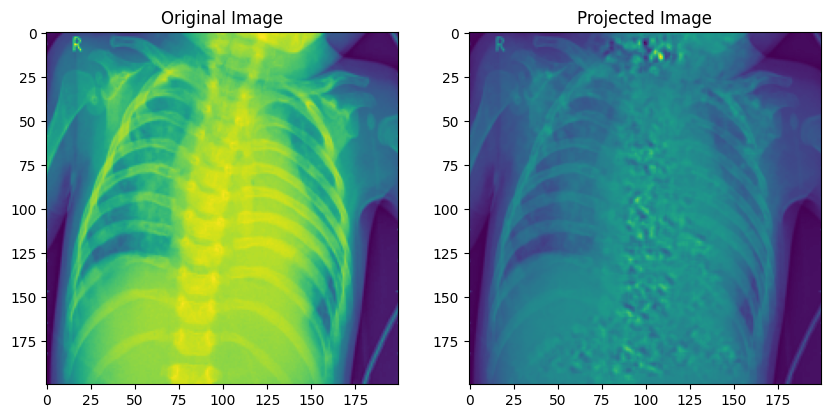

In [ ]:
## project on image
import matplotlib.pyplot as plt

# Assuming `image` is your original image and `attr_ig` is the attributions obtained from Integrated Gradients
# Both should be numpy arrays of the same shape

# Normalize attributions to [0, 1]
attr_ig_scaled = (attr_ig - attr_ig.min()) / (attr_ig.max() - attr_ig.min())

# Apply the attributions to the original image
ind = 0
print(labels[ind])
image = images[ind,0,:,:]
projected_image =  image * attr_ig_scaled[:,:,0]

# Plot the original image and the projected image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(projected_image)
plt.title('Projected Image')

plt.show()

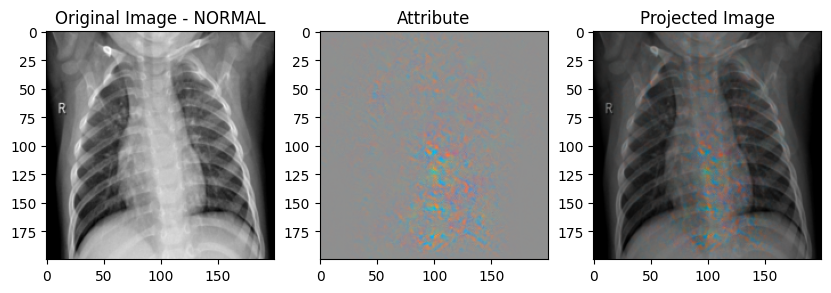

In [ ]:
## project on image
import matplotlib.pyplot as plt

# Plot one example
# get next image
images, labels = next(iter(test))

# to numpy
image = images[0].numpy()
label = labels[0].item()

# convert tensor shape (channels, height, width) to (height, width, channels)
image = np.transpose(image, (1, 2, 0))

# def classes
classes = ['NORMAL', 'PNEUMONIA']

# normalize attributions to [0, 1]
attr_ig_scaled = (attr_ig - attr_ig.min()) / (attr_ig.max() - attr_ig.min())

#project #TODO change thes one to a better overlay   Medain filter over atribution and colormap as overlay
projected_image =  image * attr_ig_scaled

# Plot the original image and the projected image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image - {}'.format(classes[label]))

plt.subplot(1, 3, 2)
plt.imshow(attr_ig_scaled)
plt.title('Attribute')

plt.subplot(1, 3, 3)
plt.imshow(projected_image)
plt.title('Projected Image')

plt.show()

In [ ]:
target_classes = []
for _, labels in test:
    target_classes.extend(labels.tolist())

print(target_classes)

[1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 

Grad-CAM

https://github.com/jacobgil/pytorch-grad-cam

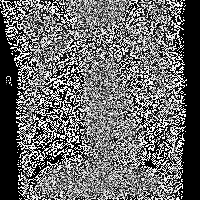

In [ ]:
from torchvision.transforms import functional as F

def attribute_image_features(algorithm, input, target_index, **kwargs):
    tensor_attributions = algorithm.attribute(input, target=target_index, **kwargs)
    return tensor_attributions

target_class_index = 0

attr_ig, delta = attribute_image_features(ig, input, target_class_index, baselines=input * 0, return_convergence_delta=True)

gradcam = torch.sum(attr_ig, dim=1, keepdim=True) * input
gradcam = F.to_pil_image(gradcam[0].cpu().detach().squeeze())
gradcam.show()
gradcam

In [ ]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38071 sha256=d123fc6c08b65e246b289ba1cd2315930a0e8084acf76dd88f59c0edf097dd19
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


In [ ]:
print(model.model.features)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke

In [ ]:
next(iter(test))

[tensor([[[[0.3014, 0.3196, 0.3059,  ..., 0.0913, 0.0868, 0.0502],
           [0.3059, 0.3288, 0.2877,  ..., 0.0913, 0.0731, 0.0731],
           [0.3242, 0.3151, 0.2740,  ..., 0.0959, 0.0594, 0.0913],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.3014, 0.3196, 0.3059,  ..., 0.0913, 0.0868, 0.0502],
           [0.3059, 0.3288, 0.2877,  ..., 0.0913, 0.0731, 0.0731],
           [0.3242, 0.3151, 0.2740,  ..., 0.0959, 0.0594, 0.0913],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.3014, 0.3196, 0.3059,  ..., 0.0913, 0.0868, 0.0502],
           [0.3059, 0.3288, 0.2877,  ..., 0.0913, 0.0731, 0.0731],
           [0.3242, 0.31

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import PIL

target_layers = [model.model.features.denseblock4]
image, label = next(iter(test))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image, label = image.to(device), label.to(device)

image = image.float()

cam = GradCAM(model=model, target_layers=target_layers)
target_category = 0

grayscale_cam = cam(input_tensor=image)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

AxisError: axis 2 is out of bounds for array of dimension 0

In [ ]:
# Initialize GradCAM
#target_layer = model.model.classifier
#target_layer = model.model.features[-1]
target_layer = [model.model.features.denseblock4]
gradcam = GradCAM(model=model, target_layers=target_layer)

# Get a batch of images and labels from the test set
# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get a batch of images and labels from the test set
images, labels = next(iter(test))

# Move the images to the device
images = images.to(device)

# Forward pass
output = model(images)
#print(type(output), output)
probs = torch.sigmoid(output)

# Generate Grad-CAM for the positive class (you can adjust the target category)
cam = gradcam(input_tensor=images, target_category=labels)

# Convert tensors to numpy arrays
input_images_np = images.cpu().numpy()
cam_np = cam.cpu().numpy()

# Normalize Grad-CAM values to [0, 1]
cam_np = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())

# Upsample Grad-CAM to input image size
cam_upsampled = [cv2.resize(cam_map, (input_img.shape[2], input_img.shape[1])) for cam_map, input_img in zip(cam_np, input_images_np)]

# Convert input images to uint8 format for visualization
input_images_uint8 = (input_images_np * 255).astype(np.uint8)

# Visualize Grad-CAM on input images
visualizations = [show_cam_on_image(input_img.transpose(1, 2, 0), cam_map) for input_img, cam_map in zip(input_images_uint8, cam_upsampled)]

# Display the visualizations
for i, visualization in enumerate(visualizations):
    cv2.imshow(f'Grad-CAM Image {i}', visualization)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
pip install torchcam

In [ ]:
from torchcam.methods import GradCAM
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

images, labels = next(iter(test))
images.to(device)

target_layer = [model.model.features.denseblock4]

cam = GradCAM(model, target_layer)

cam(class_idx=0, scores=model(images))

In [ ]:
#target_layer = model.model.classifier
#target_layer = model.model.features[-1]
#target_layer = model.model.features.denseblock4
target_layer = [model.model.features.denseblock4]
cam = GradCAM(model=model) #, input_shape=[32, 3, 200, 200]

# Get a batch of images and labels from the test set
images, labels = next(iter(test))  # Assuming 'test' is your DataLoader

# Move images to the same device as the model
images = images.to(device)

# Forward pass
output = model(images)
#print(output)
probs = torch.sigmoid(output)
#print(probs)

# Generate Grad-CAM for class index 0 (you can adjust the class index as needed)
cam(target_layer, images)

# Now, you can access the generated CAM heatmap using cam.image[0]
# For example, you can visualize it with matplotlib
import matplotlib.pyplot as plt
plt.imshow(cam.images[0], cmap='jet')
plt.axis('off')
plt.show()

In [ ]:
images.size()

In [ ]:
import sys
sys.path.append('/kaggle/input/gradcam')

In [ ]:
from gradcam import GradCAM
heatmaps = []
model.eval()

images, labels = next(iter(test))  # Assuming 'test' is your DataLoader
images = images.to(device)

preds = model(images)
i = np.argmax(preds.cpu().detach())

#target_layer = model.model.features.denseblock4
#target_layer = model.model.classifier
#target_layer = model.model.features[-1]
#target_layer = model.model.features.denseblock4
target_layers = [model.model.features.denseblock4]

cam = GradCAM(target_layer, i)
heatmap = cam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (IMG_DIM, IMG_DIM))
heatmaps.append(heatmap)

heatmaps = np.array(heatmaps,dtype='float32')

In [ ]:
## current
from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


target_layers = [model.model.features.denseblock4]
targets = [SemanticSegmentationTarget(0, 1)]
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.model.features.denseblock4]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

images, labels = next(iter(test))
images, labels = images.to(device), labels.to(device).to(torch.float32)

images.requires_grad_(True)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

predict = model(images)

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=images, targets=predict)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs


In [ ]:
from captum.attr import LayerGradCam

def attribute_image_features(algorithm, input, target, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=target, **kwargs)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    attr = np.transpose(tensor_attributions.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

    return attr


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

images, labels = next(iter(test))
images, labels = images.to(device), labels.to(device)

gc = GuidedGradCam(model, [model.model.features.denseblock4])
attr_gc = attribute_image_features(gc, images, target=labels[0])

viz.visualize_image_attr(attr_gc,
                         original_image,
                         method="heat_map",
                         sign="all",
                         show_colorbar=True,
                         title="Guided GradCAM")

Data Randomization Test

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Shuffle the labels
images, labels = next(iter(test))
shuffled_labels = labels[torch.randperm(len(labels))]

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

shuffled_dataset = CustomDataset(images, shuffled_labels)

# Create a DataLoader with the modified dataset
test_shuffled = DataLoader(shuffled_dataset, batch_size=32, shuffle=True)


In [ ]:
test_shuffled

In [ ]:
from captum.attr import IntegratedGradients

target_class_index = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# iterate batches
for batch_idx, (images, labels) in enumerate(test_shuffled):
    images.to(device)
    labels.to(device)

    for img_idx, img_tensor in enumerate(images):
        input = img_tensor.unsqueeze(0).to(device)
        input.requires_grad = True

        # Integrated Gradients
        ig = IntegratedGradients(model)

        # attribute
        attr_ig_shuffeld, delta_shuffeld = attribute_image_features(ig, input, target_class_index, baselines=input * 0, return_convergence_delta=True)
        attr_ig_shuffeld = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
        print(f'Approximation delta for Batch {batch_idx}, Image {img_idx}: ', abs(delta_shuffeld))

In [ ]:
#Integrated gradients on shuffeld data
images, labels = next(iter(test_shuffled))

# to numpy
image = images[0].numpy()
label = labels[0].item()

# convert tensor shape (channels, height, width) to (height, width, channels)
image = np.transpose(image, (1, 2, 0))

# def classes
classes = ['NORMAL', 'PNEUMONIA']

# normalize attributions to [0, 1]
attr_ig_scaled = (attr_ig_shuffeld - attr_ig_shuffeld.min()) / (attr_ig_shuffeld.max() - attr_ig_shuffeld.min())

#project
projected_image =  image * attr_ig_scaled

# Plot the original image and the projected image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image - Shuffled')

plt.subplot(1, 3, 2)
plt.imshow(attr_ig_scaled)
plt.title('Attribute')

plt.subplot(1, 3, 3)
plt.imshow(projected_image)
plt.title('Projected Image')

plt.show()